# Supervised Classification Module (exercise)

**Lecturer:** Ashish Mahabal<br>
**Jupyter Notebook Authors:** Ashish Mahabal & Yuhan Yao

This is a Jupyter notebook lesson extending the GROWTH Summer School 2019 and adapted for the NARIT-EACOA 2019 summer workshop.

## Objective
Classify different classes using (a) decision trees and (b) random forest 

## Key steps
- Pick variable types
- Select training sample
- Select method
- Look at confusion matrix and details 

## Required dependencies

See GROWTH school webpage for detailed instructions on how to install these modules and packages.  Nominally, you should be able to install the python modules with `pip install <module>`.  The external astromatic packages are easiest installed using package managers (e.g., `rpm`, `apt-get`).

### Python modules
* python 3
* astropy
* numpy
* astroquery
* pandas
* matplotlib
* pydotplus
* IPython.display
* sklearn

### External packages
None

### Partial Credits
Pavlos Protopapas (LSSDS notebook)

## Now you will do a similar set of analyses on a different dataset.
### Here you will use the light curves file to derive features
### And then use the resulting file to run decision trees and random forest on that for classification

#### import the required modules (exercise)

In [53]:
import numpy as np
import pandas as pd
import os

# For inline plots
%matplotlib inline

import matplotlib.pyplot as plt

import io
import pydotplus
from IPython.display import Image

# Various scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#### read the lightcurves file

In [2]:
datadir = 'data'
lightcurves = datadir + '/CRTS_6varclasses.csv.gz'

In [27]:
lcs = pd.read_csv(lightcurves,
                 compression='gzip',
                 header=1,
                 sep=',',
                 skipinitialspace=True,
                 nrows=100000)
                 #skiprows=[4,5])
                 #,nrows=100000)

lcs.columns = ['ID', 'MJD', 'Mag', 'magerr', 'RA', 'Dec']
lcs.head()

,ID,MJD,Mag,magerr,RA,Dec
0,1109065026725,53705.501925,16.943797,0.082004,182.25871,9.76580
1,1109065026725,53731.483314,16.645102,0.075203,182.25867,9.76585
2,1109065026725,53731.491406,16.693791,0.076497,182.25870,9.76574
3,1109065026725,53731.499465,16.793651,0.078755,182.25869,9.76576
4,1109065026725,53731.507529,16.767817,0.077436,182.25878,9.76581


In [4]:
len(lcs)

100000

#### We need classes, so load the catalog file too

In [5]:
catalog = datadir + '/CatalinaVars.tbl.gz'

In [6]:
cat = pd.read_csv(catalog,
                 compression='gzip',
                 header=5,
                 sep=' ',
                 skipinitialspace=True,
                 )

columns = cat.columns[1:]
cat = cat[cat.columns[:-1]]
cat.columns = columns

cat.head()

,Catalina_Surveys_ID,Numerical_ID,RA_J2000,Dec,V_mag,Period_days,Amplitude,Number_Obs,Var_Type
0,CSS_J000020.4+103118,1109001041232,00:00:20.41,+10:31:18.9,14.62,1.491758,2.39,223,2
1,CSS_J000031.5-084652,1009001044997,00:00:31.50,-08:46:52.3,14.14,0.404185,0.12,163,1
2,CSS_J000036.9+412805,1140001063366,00:00:36.94,+41:28:05.7,17.39,0.274627,0.73,158,1
3,CSS_J000037.5+390308,1138001069849,00:00:37.55,+39:03:08.1,17.74,0.30691,0.23,219,1
4,CSS_J000103.3+105724,1109001050739,00:01:03.37,+10:57:24.4,15.25,1.5837582,0.11,223,8


In [7]:
RRd = cat[ cat['Var_Type'].isin([6]) & (cat['Number_Obs']>100) ]

In [8]:
RRd.head()

,Catalina_Surveys_ID,Numerical_ID,RA_J2000,Dec,V_mag,Period_days,Amplitude,Number_Obs,Var_Type
115,CSS_J001420.8+031214,1104002007409,00:14:20.84,+03:12:14.0,17.45,0.3871100,0.56,174,6
198,CSS_J001724.9+200542,1121002007726,00:17:24.90,+20:05:42.2,16.64,0.3571291,0.39,224,6
214,CSS_J001812.9+210201,1121002027610,00:18:12.97,+21:02:01.5,14.54,0.41616,0.34,224,6
531,CSS_J003001.7+094947,1109003028079,00:30:01.71,+09:49:47.6,16.91,0.3729404,0.36,212,6
640,CSS_J003359.4+022609,1101004049971,00:33:59.48,+02:26:09.0,15.87,0.3601025,0.27,195,6


### Get numerical ids of objects belonging to the RRd class - call them RRds

In [9]:
RRds = RRd['Numerical_ID']

In [10]:
RRds.head()

115    1104002007409
198    1121002007726
214    1121002027610
531    1109003028079
640    1101004049971
Name: Numerical_ID, dtype: int64

### Let us extract some features from the mags (lets ignore the mag errors for now)

#### For a given id you could do it as follows. isin() accepts a list so you could use the entire RRds there
#### you will lose the id infor if you do that in a single step, so you could break it up

In [11]:
lcs[lcs['ID'].isin(['1109065026725'])]['Mag']

0      16.943797
1      16.645102
2      16.693791
3      16.793651
4      16.767817
         ...    
394    16.461535
395    16.891826
396    16.824519
397    16.787664
398    16.816125
Name: Mag, Length: 399, dtype: float64

In [12]:
lcs[lcs['ID'].isin(RRds)]['Mag']

1212     14.998325
1213     14.984769
1214     15.010683
1215     14.984963
1216     14.817003
           ...    
98439    16.241040
98440    16.298755
98441    16.282934
98442    16.270512
98443    16.301170
Name: Mag, Length: 6340, dtype: float64

#### Lets assign mags for '1109065026725' to mags (a dictionary)

In [13]:
mags = {}
mags['1109065026725'] = lcs[lcs['ID'].isin(['1109065026725'])]['Mag']

#### Let us get the mean of mags for this one particular object: '1109065026725'

In [14]:
np.mean(mags['1109065026725'].values)

16.717012834586466

#### Assign it to another dictionary with the same key

In [15]:
means = {}
means['1109065026725'] = np.mean(mags['1109065026725'].values)

## Exercise!

### Get mean, median, skew, kurtosis for all ids in our light curves set

In [16]:
from scipy.stats import skew, kurtosis

print("id: 1109065026725")
print("mean: ", np.mean(mags['1109065026725']))
print("median: ", np.median(mags['1109065026725']))
print("skew: ", skew(mags['1109065026725']))
print("kurtosis: ", kurtosis(mags['1109065026725']))

id: 1109065026725
mean:  16.717012834586466
median:  16.729198
skew:  -0.19222112044199696
kurtosis:  -1.2417932925339292


In [17]:
lcs[lcs['ID'].isin(['1109065026725'])]['Mag']

0      16.943797
1      16.645102
2      16.693791
3      16.793651
4      16.767817
         ...    
394    16.461535
395    16.891826
396    16.824519
397    16.787664
398    16.816125
Name: Mag, Length: 399, dtype: float64

#### Define the dictionaries that you need

In [18]:
mags = {}
mean_dict = {}
median_dict = {}
skew_dict = {}
kurtosis_dict = {}

In [129]:
for idx in lcs['ID']:
    if idx in mags.keys():
        continue
    mag = lcs[lcs['ID'].isin([idx])]['Mag']
    mags[idx] = mag
    mean_dict[idx] = np.mean(mag)
    median_dict[idx] = np.median(mag)
    skew_dict[idx] = skew(mag)
    kurtosis_dict[idx] = kurtosis(mag)

In [130]:
kurtosis_dict

{1109065026725: -1.2417932925339292,
 1109065029273: 0.2226358696914854,
 1109065034047: -0.7181632898984316,
 1109065046918: -0.57769425055496,
 1109066010210: -0.9595383203095258,
 1109066011253: 30.966444462624203,
 1109066019991: 10.706311043593034,
 1109066032198: 13.497195138992446,
 1109066034003: 10.978356679300148,
 1109066042458: 60.96011081192476,
 1109066043775: 2.060384151507243,
 1109066046521: 105.64252310380445,
 1109066047711: 4.969123338597497,
 1109066056028: -0.10812947605636358,
 1109067010037: 0.8530725710525395,
 1109067012603: 0.30220404942963475,
 1109067025940: -0.13917081443977963,
 1109067029279: 8.291454825410984,
 1109067029409: -1.3060208242449889,
 1109067032215: 2.4177677566853646,
 1109067033234: 5.467601446457143,
 1109067035809: 3.3571948325193386,
 1109067045481: -0.1622176435160827,
 1109067059739: -0.9656799305012327,
 1109068010088: -0.23700553922506584,
 1109068019758: 1.7417407525705704,
 1109068048011: 1.0308937260208246,
 1109068058828: 2.182

In [133]:
# # lcs = lcs.join(pd.DataFrame(kurtosis_dict, index=lcs['ID']))
# lcs['kurtosis'] = np.array(list(kurtosis_dict.values()))

## Back to the Catalog file... check class distribution

In [45]:
cat

,Catalina_Surveys_ID,Numerical_ID,RA_J2000,Dec,V_mag,Period_days,Amplitude,Number_Obs,Var_Type
0,CSS_J000020.4+103118,1109001041232,00:00:20.41,+10:31:18.9,14.62,1.491758,2.39,223,2
1,CSS_J000031.5-084652,1009001044997,00:00:31.50,-08:46:52.3,14.14,0.404185,0.12,163,1
2,CSS_J000036.9+412805,1140001063366,00:00:36.94,+41:28:05.7,17.39,0.274627,0.73,158,1
3,CSS_J000037.5+390308,1138001069849,00:00:37.55,+39:03:08.1,17.74,0.30691,0.23,219,1
4,CSS_J000103.3+105724,1109001050739,00:01:03.37,+10:57:24.4,15.25,1.5837582,0.11,223,8
...,...,...,...,...,...,...,...,...,...
47050,CSS_J235944.2+385402,1138103069250,23:59:44.29,+38:54:02.4,16.84,0.3760653,0.29,176,5
47051,CSS_J235945.5+303731,1129113065531,23:59:45.58,+30:37:31.8,13.91,2.68655,1.53,215,2
47052,CSS_J235946.8+371110,1138103015911,23:59:46.82,+37:11:10.0,14.87,0.2889071,0.35,176,6
47053,CSS_J235948.2+382305,1138103053189,23:59:48.20,+38:23:05.5,16.50,0.341662,0.41,176,1


In [46]:
cat['Var_Type'].value_counts()

1     30745
5      5466
2      4683
4      2431
8      1521
13      512
6       502
3       279
11      242
17      153
14      143
10      124
16       85
7        73
9        64
15       25
12        7
Name: Var_Type, dtype: int64

In [49]:
varsAll = cat[ cat['Var_Type'].isin([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]) & (cat['Number_Obs']>100) ]
varsAll.head()

,Catalina_Surveys_ID,Numerical_ID,RA_J2000,Dec,V_mag,Period_days,Amplitude,Number_Obs,Var_Type
0,CSS_J000020.4+103118,1109001041232,00:00:20.41,+10:31:18.9,14.62,1.491758,2.39,223,2
1,CSS_J000031.5-084652,1009001044997,00:00:31.50,-08:46:52.3,14.14,0.404185,0.12,163,1
2,CSS_J000036.9+412805,1140001063366,00:00:36.94,+41:28:05.7,17.39,0.274627,0.73,158,1
3,CSS_J000037.5+390308,1138001069849,00:00:37.55,+39:03:08.1,17.74,0.30691,0.23,219,1
4,CSS_J000103.3+105724,1109001050739,00:01:03.37,+10:57:24.4,15.25,1.5837582,0.11,223,8


## Helper Functions for Visualization

In [59]:
def display_dt(dt):
    dummy_io = io.StringIO() 
    tree.export_graphviz(dt, out_file = dummy_io, proportion=True) 
    print(dummy_io.getvalue())

In [60]:
# This function creates images of tree models using pydotplus
# https://github.com/JWarmenhoven/ISLR-python
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = io.StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, proportion=True, class_names=classn, filled=filled)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)

In [61]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask.any() !=None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return(clf, Xtrain, ytrain, Xtest, ytest)

## Now run decision tree and random forest using these variables by picking a couple of classes

### We start by picking two classes: 2 and 5

In [69]:
vars2 = varsAll[ varsAll['Var_Type'].isin([2,5])  ]
vars2.head()

,Catalina_Surveys_ID,Numerical_ID,RA_J2000,Dec,V_mag,Period_days,Amplitude,Number_Obs,Var_Type
0,CSS_J000020.4+103118,1109001041232,00:00:20.41,+10:31:18.9,14.62,1.491758,2.39,223,2
16,CSS_J000216.1-165109,1015001002091,00:02:16.16,-16:51:09.7,16.07,0.30487,0.17,124,5
23,CSS_J000309.5+193816,1118001060639,00:03:09.56,+19:38:16.6,17.82,1.12582,0.59,206,2
28,CSS_J000358.9+122734,1112001023767,00:03:58.94,+12:27:34.8,16.66,0.673614,0.51,205,2
29,CSS_J000400.6-090352,1009001039815,00:04:00.60,-09:03:52.6,18.49,0.228456,0.40,176,5


In [72]:
Y = vars2['Var_Type'].values
Y = np.array([1 if y==6 else 0 for y in Y])
X = vars2.drop('Var_Type',1)
vars2.loc[:,('target')] = Y
# Create test/train mask
itrain, itest = train_test_split(range(vars2.shape[0]), train_size=0.6)
mask=np.ones(vars2.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

/home/abao/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/abao/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [73]:
clfTree1 = tree.DecisionTreeClassifier(max_depth=3, criterion='gini')

subdf=vars2[['V_mag', 'Period_days']]
X=subdf.values
y=(vars2['Var_Type'].values==1)*1

# TRAINING AND TESTING
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]

# FIT THE TREE 
clf=clfTree1.fit(Xtrain, ytrain)

training_accuracy = clf.score(Xtrain, ytrain)
test_accuracy = clf.score(Xtest, ytest)
print("############# based on standard predict ################")
print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))
print(confusion_matrix(ytest, clf.predict(Xtest)))
print("########################################################")

############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     1.00
[[3905]]
########################################################


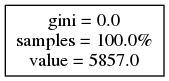

In [74]:
graph3 = print_tree(clf, features=['V_mag', 'Period_days'], class_names=['No', 'Yes'])
Image(graph3.create_png())

### Generalize the previous steps by making a function that can take in variables and classes of interest

In [36]:
def dtclassify(allclasses,class1,class2,var1,var2):
    vars2 = allclasses[ allclasses['Var_Type'].isin([class1,class2])  ]
    Y = vars2['Var_Type'].values
    Y = np.array([1 if y==6 else 0 for y in Y])
#    X = vars2.drop('Var_Type',1).as_matrix()
    X = vars2.drop('Var_Type',1)
#    vars2['target'] = (vars2['Var_Type'].values==class1)*1
    vars2.loc[:,('target')] = Y
    
    # Create test/train mask
    itrain, itest = train_test_split(range(vars2.shape[0]), train_size=0.6)
    mask=np.ones(vars2.shape[0], dtype='int')
    mask[itrain]=1
    mask[itest]=0
    mask = (mask==1)
    
    print("% Class ",class1," objects in Training:", np.mean(vars2.target[mask]), np.std((vars2.target[mask])))
    print("% Class ",class2," objects in Testing:", np.mean(vars2.target[~mask]), np.std((vars2.target[~mask])))
    
    clfTree1 = tree.DecisionTreeClassifier(max_depth=3, criterion='gini')

    subdf=vars2[[var1, var2]]
    X=subdf.values
#    y=(vars2['target'].values==1)*1
#    print('y is ',y[:10])
    y = vars2.loc[:,('target')].values==1*1
#    print('y is ',y[:10])

    # TRAINING AND TESTING
    Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]

    # FIT THE TREE 
    clf=clfTree1.fit(Xtrain, ytrain)

    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    
    display_dt(clf)
    return [clf,var1,var2]
    
#    graph3 = print_tree(clf, features=[var1, var2], class_names=['No', 'Yes'])
#    Image(graph3.create_png())
    

In [92]:
[clf,var1,var2] = dtclassify(varsAll,1,6,'V_mag','Amplitude')

% Class  1  objects in Training: 0.017011834319526627 0.12931524199648425
% Class  6  objects in Testing: 0.01638504864311316 0.12695108831388058
############# based on standard predict ################
Accuracy on training data: 0.98
Accuracy on test data:     0.98
[[11526     0]
 [  192     0]]
########################################################
digraph Tree {
node [shape=box] ;
0 [label="X[1] <= 0.285\ngini = 0.033\nsamples = 100.0%\nvalue = [0.983, 0.017]"] ;
1 [label="X[0] <= 12.165\ngini = 0.013\nsamples = 40.5%\nvalue = [0.994, 0.006]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="X[1] <= 0.225\ngini = 0.375\nsamples = 0.0%\nvalue = [0.75, 0.25]"] ;
1 -> 2 ;
3 [label="gini = 0.0\nsamples = 0.0%\nvalue = [0.0, 1.0]"] ;
2 -> 3 ;
4 [label="gini = 0.0\nsamples = 0.0%\nvalue = [1.0, 0.0]"] ;
2 -> 4 ;
5 [label="X[1] <= 0.185\ngini = 0.013\nsamples = 40.5%\nvalue = [0.994, 0.006]"] ;
1 -> 5 ;
6 [label="gini = 0.003\nsamples = 18.5%\nvalue = [0.998, 0.0

/home/abao/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/abao/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


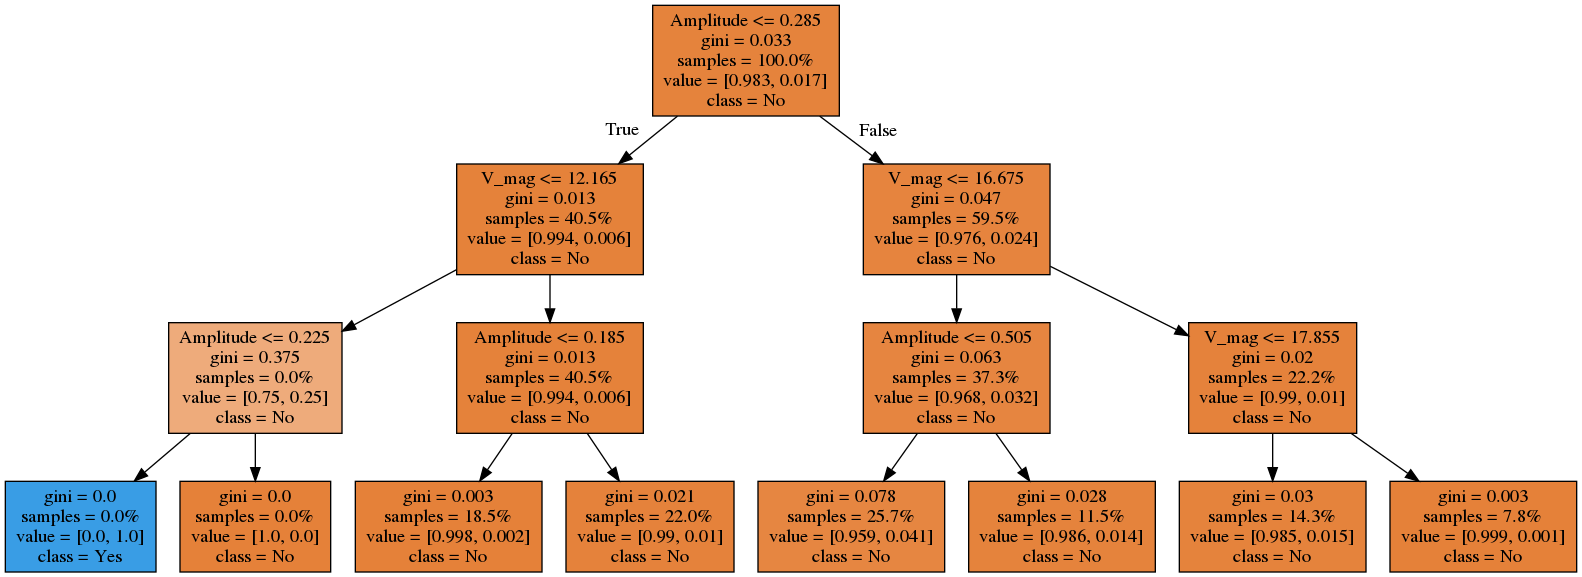

In [93]:
graph3 = print_tree(clf, features=['V_mag', 'Amplitude'], class_names=['No', 'Yes'])
Image(graph3.create_png())

In [99]:
lcs

,ID,MJD,Mag,magerr,RA,Dec
0,1109065026725,53705.501925,16.943797,0.082004,182.25871,9.76580
1,1109065026725,53731.483314,16.645102,0.075203,182.25867,9.76585
2,1109065026725,53731.491406,16.693791,0.076497,182.25870,9.76574
3,1109065026725,53731.499465,16.793651,0.078755,182.25869,9.76576
4,1109065026725,53731.507529,16.767817,0.077436,182.25878,9.76581
...,...,...,...,...,...,...
99995,1109114052037,56188.258750,16.923484,0.081717,322.87284,9.92439
99996,1109114052037,56205.093941,16.861170,0.084467,322.87283,9.92444
99997,1109114052037,56205.101255,16.831480,0.088023,322.87280,9.92440
99998,1109114052037,56205.108529,16.927803,0.083850,322.87286,9.92440


#### Use LCS file now

In [100]:
[clf,var1,var2] = dtclassify(lcs,0,1,'Mag','Dec')

KeyError: 'Var_Type'

In [96]:
# clfForest = RandomForestClassifier(n_estimators=10, oob_score=True, max_features='auto')
# features['target'] = features['Var_Type']

# subdf=features[Xnames]
# X=subdf.values
# y=(features['target'].values==1)*1

# # Create test/train mask
# itrain, itest = train_test_split(range(features.shape[0]), train_size=0.6)
# mask=np.ones(features.shape[0], dtype='int')
# mask[itrain]=1
# mask[itest]=0
# mask = (mask==1)
    

# # TRAINING AND TESTING
# Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]

# # FIT THE TREE 
# clf=clfForest.fit(Xtrain, ytrain)

# print(clfForest.n_estimators)

# training_accuracy = clfForest.score(Xtrain, ytrain)
# test_accuracy = clfForest.score(Xtest, ytest)
# print("############# based on standard predict ################")
# print("Accuracy on training data: %0.2f" % (training_accuracy))
# print("Accuracy on test data:     %0.2f" % (test_accuracy))
# print(confusion_matrix(ytest, clf.predict(Xtest)))
# print("########################################################")

# parameters = {"n_estimators": list(range(1, 20))}
# clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
#                                                        features, Xnames, 'target', 1, mask=mask, 
#                                                        n_jobs = 4, score_func='f1')
# print(clfForest.n_estimators)